In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import re

In [2]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (filtering, calc_binding_concordance)

In [3]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [4]:
from itertools import chain, combinations
def all_combinations(ss):
    return [list(subset) for subset in chain(*map(lambda x: combinations(ss, x), range(1, len(ss)+1)))]

#for subset in all_subsets(df.tcr_category.unique()):
#    print(list(subset))

# Input

In [5]:
INPUT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'

# Load

In [6]:
df = pd.read_csv(INPUT, converters=converters).fillna(0)

In [7]:
df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr3_TRA',
       'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA', 'cdr3_lst_TRA',
       'chain_count_TRA', 'single_TRA', 'length_TRB', 'cdr3_TRB',
       'umi_count_TRB', 'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB',
       'chain_count_TRB', 'single_TRB', 'single_chain_only', 'umi_count_tcr',
       'cdr3_comb', 'tcr_category', 'no_filtration',
       'exclude_single-chain_TCRs', 'exclude_ambiguous_and_single-chain_TCRs',
       'template_id_mhc', 'template_lst_mhc', 'single_barcode_mhc',
       'umi_count_mhc', 'umi_count_lst_mhc', 'read_count_mhc',
       'read_count_lst_mhc', 'multiplets_mhc', 'delta_umi_mhc',
       'template_id_cd8', 'template_lst_cd8', 'single_barcode_cd8',
       'umi_count_cd8', 'umi_count_lst_cd8', 'read_count_cd8',
       'read_count_lst_cd8', 'detected_response', 'peptide_assayed',
       'sample_id', 'sample_id

In [8]:
umi_count_TRA_l = np.arange(0,10,2)
umi_count_TRB_l = np.arange(0,20,4)
delta_umi_TRA_l = np.arange(0,10,5)
delta_umi_TRB_l = np.arange(0,10,5)
tcr_category_l = [['unique chains'],['unique chains', 'multiple chains', 'missing chain']]
umi_count_mhc_l = np.arange(0,20,5)
delta_umi_mhc_l = np.arange(0,10,3)
single_barcode_mhc_l = [[True], [False, True]]
exclude_specificity_singlet_l = np.array([True, False])

In [9]:
observations = (len(umi_count_TRA_l) *
                len(umi_count_TRB_l) *
                len(delta_umi_TRA_l) *
                len(delta_umi_TRB_l) *
                len(tcr_category_l) *
                len(umi_count_mhc_l) *
                len(delta_umi_mhc_l) *
                len(single_barcode_mhc_l) *
                len(exclude_specificity_singlet_l))

In [10]:
observations

12800

In [11]:
features = ['umi_count_TRA','delta_umi_TRA','umi_count_TRB','delta_umi_TRB','tcr_category',
            'umi_count_mhc','delta_umi_mhc','single_barcode_mhc', 'exclude_specificity_singlet',
            'concordance', 'n_gems', 'n_tcrs']
table = pd.DataFrame(columns=features)

In [12]:
i = -1
for uca in umi_count_TRA_l:
    for dua in delta_umi_TRA_l:
        for ucb in umi_count_TRB_l:
            for dub in delta_umi_TRB_l:
                for tc in tcr_category_l:
                    for ucm in umi_count_mhc_l:
                        for dum in delta_umi_mhc_l:
                            for sbm in single_barcode_mhc_l:
                                for ess in exclude_specificity_singlet_l:
                                    i += 1
                                    filter_bool = ((df.umi_count_TRA >= uca) &
                                                   (df.delta_umi_TRA >= dua) &
                                                   (df.umi_count_TRB >= ucb) &
                                                   (df.delta_umi_TRB >= dub) &
                                                   (df.tcr_category.isin(tc)) &
                                                   (df.umi_count_mhc >= ucm) &
                                                   (df.delta_umi_mhc >= dum) &
                                                   (df.single_barcode_mhc.isin(sbm)))
                                    
                                    flt = df[filter_bool].copy()
                                    
                                    if ess:
                                        flt = flt[flt.duplicated(subset=['ct', 'peptide_HLA'], keep=False)]
                                        
                                    flt = calc_binding_concordance(flt, 'ct')
                                    
                                    n_gems = len(flt)
                                    n_tcrs = len(flt.ct.unique())
                                    conc = flt.binding_concordance.mean()
                                    
                                    table.loc[i] = (uca, dua, ucb, dub, tc, ucm, dum, sbm, ess, conc, n_gems, n_tcrs)
                                    
                                    print(i, n_gems, conc)
                                

0 573 0.3483158088965754
1 766 0.3950326502050268
2 1529 0.5101131812954226
3 1819 0.4966809481837903
4 573 0.3483158088965754
5 766 0.3950326502050268
6 1311 0.5565928247873603
7 1545 0.5403238873393177
8 66 0.6077823691460055
9 87 0.651751505199781
10 746 0.8724600855250887
11 812 0.8509824570543534
12 18 1.0
13 30 0.8574074074074075
14 649 0.9519116322814319
15 700 0.9283788165476907
16 16 1.0
17 25 1.0
18 777 0.9313036480738344
19 847 0.8860911152089106
20 16 1.0
21 25 1.0
22 743 0.9528331065557022
23 801 0.9174295825612165
24 16 1.0
25 25 1.0
26 697 0.9602316892207988
27 750 0.9312471577183521
28 16 1.0
29 25 1.0
30 645 0.9573848451502649
31 695 0.9331450864678237
32 15 1.0
33 22 1.0
34 766 0.930355067541978
35 827 0.8919105784398287
36 15 1.0
37 22 1.0
38 735 0.9523464956852326
39 788 0.9226261086966555
40 15 1.0
41 22 1.0
42 695 0.9601175149535387
43 745 0.9352796693010675
44 15 1.0
45 22 1.0
46 644 0.957318986238491
47 692 0.9352643069839601
48 13 1.0
49 20 1.0
50 745 0.9402031

388 482 0.3577671329746019
389 655 0.4055998545124849
390 1166 0.5789085198836063
391 1380 0.5575033991211256
392 61 0.5827123695976155
393 78 0.6171051171051172
394 691 0.878149047158203
395 752 0.8534767339513968
396 16 1.0
397 27 0.8415637860082305
398 600 0.960061879819239
399 649 0.9339736566111099
400 14 1.0
401 22 1.0
402 716 0.946257323367601
403 785 0.893404761225139
404 14 1.0
405 22 1.0
406 687 0.9648456532135844
407 744 0.9233343539756728
408 14 1.0
409 22 1.0
410 645 0.9682555365232443
411 696 0.9365476556418486
412 14 1.0
413 22 1.0
414 596 0.9660243795793769
415 644 0.9391397363649909
416 13 1.0
417 19 1.0
418 707 0.9455802849396736
419 767 0.9000339003901565
420 13 1.0
421 19 1.0
422 680 0.9644848864279635
423 732 0.9290477440737679
424 13 1.0
425 19 1.0
426 643 0.9681569320976195
427 691 0.9408269495247777
428 13 1.0
429 19 1.0
430 595 0.9659674359293602
431 641 0.9414554013697037
432 12 1.0
433 18 1.0
434 692 0.9470199424267721
435 745 0.9117599880397445
436 12 1.0
43

801 3 1.0
802 222 0.9565082323703014
803 249 0.91019379531549
804 0 nan
805 3 1.0
806 214 0.981571673028827
807 240 0.9408390410958903
808 0 nan
809 3 1.0
810 201 1.0
811 225 0.9692644757433492
812 0 nan
813 3 1.0
814 186 1.0
815 213 0.967550400441867
816 0 nan
817 2 1.0
818 218 0.9557436361286987
819 243 0.9203065134099617
820 0 nan
821 2 1.0
822 211 0.9813154215963723
823 236 0.9479887801384578
824 0 nan
825 2 1.0
826 198 1.0
827 222 0.9688573465551882
828 0 nan
829 2 1.0
830 183 1.0
831 210 0.967096312209094
832 84 0.384203681472589
833 179 0.5560475292733971
834 389 0.6471179058439841
835 541 0.6148961837206693
836 84 0.384203681472589
837 179 0.5560475292733971
838 337 0.6973185579354473
839 471 0.6643472607996364
840 9 0.6825396825396826
841 21 0.7976190476190477
842 238 0.9302077096194745
843 288 0.9099556547818138
844 0 nan
845 6 1.0
846 212 1.0
847 259 0.9694501592311813
848 0 nan
849 5 1.0
850 258 0.9553613235523646
851 311 0.906115588591473
852 0 nan
853 5 1.0
854 248 0.9763

1264 0 nan
1265 1 1.0
1266 91 0.9370182056749219
1267 118 0.8987205051512132
1268 0 nan
1269 1 1.0
1270 86 1.0
1271 113 0.944757307589166
1272 0 nan
1273 1 1.0
1274 84 1.0
1275 105 0.9812454212454214
1276 0 nan
1277 1 1.0
1278 76 1.0
1279 98 0.9799263967882236
1280 525 0.34590800686323075
1281 700 0.3907164802876214
1282 1358 0.5041377149413075
1283 1614 0.4877565486503855
1284 525 0.34590800686323075
1285 700 0.3907164802876214
1286 1162 0.5433655909482619
1287 1374 0.5283263866356416
1288 62 0.5824780058651027
1289 80 0.6212797619047619
1290 651 0.8651368245666685
1291 709 0.8410545661852515
1292 17 1.0
1293 27 0.8415637860082305
1294 560 0.956736767995257
1295 605 0.9288677573725869
1296 15 1.0
1297 22 1.0
1298 670 0.941646933869976
1299 732 0.8905032082975736
1300 15 1.0
1301 22 1.0
1302 643 0.953443968498401
1303 693 0.9177302292830243
1304 15 1.0
1305 22 1.0
1306 604 0.9657042799368672
1307 651 0.9318741931629223
1308 15 1.0
1309 22 1.0
1310 556 0.9631104419706572
1311 600 0.9343

1644 12 1.0
1645 17 1.0
1646 527 0.9624111994066158
1647 577 0.9359310486095772
1648 11 1.0
1649 16 1.0
1650 619 0.9377353274494027
1651 677 0.9014928705732123
1652 11 1.0
1653 16 1.0
1654 597 0.9477534520726073
1655 648 0.9246837449265497
1656 11 1.0
1657 16 1.0
1658 565 0.960929905885658
1659 616 0.9326799153714493
1660 11 1.0
1661 16 1.0
1662 521 0.9619793721101673
1663 570 0.938108659476787
1664 450 0.35516659128599426
1665 605 0.4028486789258894
1666 1217 0.5205415483569887
1667 1452 0.5035659978644197
1668 450 0.35516659128599426
1669 605 0.4028486789258894
1670 1050 0.5609185877714044
1671 1241 0.5475042258849988
1672 57 0.5534290271132376
1673 73 0.5908794401945088
1674 612 0.8686426068011746
1675 667 0.8423384519237962
1676 15 1.0
1677 25 0.8288888888888889
1678 527 0.961330643237595
1679 571 0.9315225467189985
1680 13 1.0
1681 20 1.0
1682 627 0.9495603660075774
1683 688 0.8945229005280193
1684 13 1.0
1685 20 1.0
1686 603 0.9627525335788146
1687 653 0.9215693634686721
1688 13 

2036 3 1.0
2037 7 1.0
2038 403 0.9808345472642903
2039 433 0.9531166329633203
2040 3 1.0
2041 7 1.0
2042 384 0.9902146464646465
2043 413 0.9648005137130979
2044 3 1.0
2045 7 1.0
2046 356 0.9895389383959706
2047 385 0.9623896103896104
2048 77 0.4030656843156843
2049 134 0.5337893864013267
2050 313 0.6163565406740027
2051 399 0.5918284548617595
2052 77 0.4030656843156843
2053 134 0.5337893864013267
2054 273 0.6611022311022311
2055 347 0.6419502323855426
2056 9 0.6825396825396826
2057 18 0.7638888888888888
2058 190 0.922343464940966
2059 219 0.8945464679595493
2060 0 nan
2061 5 1.0
2062 171 1.0
2063 195 0.9645796064400716
2064 0 nan
2065 4 1.0
2066 200 0.961159420289855
2067 226 0.9144168847895634
2068 0 nan
2069 4 1.0
2070 192 0.9794753086419754
2071 217 0.9434649034929541
2072 0 nan
2073 4 1.0
2074 181 1.0
2075 205 0.9662872628726288
2076 0 nan
2077 4 1.0
2078 171 1.0
2079 194 0.9643970270918245
2080 0 nan
2081 3 1.0
2082 199 0.9609727469464112
2083 223 0.9217595558402732
2084 0 nan
208

2484 0 nan
2485 0 nan
2486 73 1.0
2487 89 0.9449075752084088
2488 0 nan
2489 0 nan
2490 71 1.0
2491 84 0.9765807962529272
2492 0 nan
2493 0 nan
2494 66 1.0
2495 78 0.97480881691408
2496 26 0.4082840236686391
2497 47 0.594224924012158
2498 121 0.617190082644628
2499 160 0.6143154761904762
2500 26 0.4082840236686391
2501 47 0.594224924012158
2502 104 0.7003933566433567
2503 139 0.6896882494004796
2504 0 nan
2505 5 1.0
2506 74 1.0
2507 91 0.9618873190301764
2508 0 nan
2509 1 1.0
2510 68 1.0
2511 81 0.9757343550446997
2512 0 nan
2513 0 nan
2514 82 0.9302591463414634
2515 98 0.8797155225726654
2516 0 nan
2517 0 nan
2518 75 1.0
2519 92 0.946687370600414
2520 0 nan
2521 0 nan
2522 73 1.0
2523 86 0.9771192798199552
2524 0 nan
2525 0 nan
2526 68 1.0
2527 80 0.9754310344827584
2528 0 nan
2529 0 nan
2530 82 0.9302591463414634
2531 97 0.897594501718213
2532 0 nan
2533 0 nan
2534 75 1.0
2535 92 0.946687370600414
2536 0 nan
2537 0 nan
2538 73 1.0
2539 86 0.9771192798199552
2540 0 nan
2541 0 nan
2542

2886 1128 0.5765988355181878
2887 1365 0.5607266298947726
2888 60 0.5757575757575759
2889 80 0.6266774891774892
2890 661 0.8701449622696927
2891 740 0.8396473641076709
2892 17 1.0
2893 28 0.8472222222222222
2894 571 0.9560133736666135
2895 633 0.92585372080433
2896 15 1.0
2897 21 1.0
2898 691 0.938880733873498
2899 778 0.881446855265998
2900 15 1.0
2901 21 1.0
2902 658 0.9497566774555097
2903 733 0.9066320284178458
2904 15 1.0
2905 21 1.0
2906 616 0.9614069274329027
2907 681 0.9204306929429239
2908 15 1.0
2909 21 1.0
2910 567 0.962146620085059
2911 626 0.93078899847201
2912 14 1.0
2913 18 1.0
2914 682 0.9381753898727904
2915 759 0.8877506466391633
2916 14 1.0
2917 18 1.0
2918 651 0.9492870038407698
2919 719 0.9119072716163034
2920 14 1.0
2921 18 1.0
2922 614 0.961281569318638
2923 676 0.9247353275534553
2924 14 1.0
2925 18 1.0
2926 566 0.96207993027781
2927 623 0.9328638890827461
2928 13 1.0
2929 17 1.0
2930 670 0.9396068240939683
2931 739 0.898792769892414
2932 13 1.0
2933 17 1.0
2934

3280 5 1.0
3281 11 1.0
3282 440 0.9691928486186859
3283 488 0.9234130016432
3284 5 1.0
3285 11 1.0
3286 426 0.9818670095143752
3287 469 0.9468374754342948
3288 5 1.0
3289 11 1.0
3290 400 0.9906060606060606
3291 436 0.9637497490145323
3292 5 1.0
3293 11 1.0
3294 371 0.9899618923691793
3295 406 0.9636758663712436
3296 4 1.0
3297 8 1.0
3298 435 0.9688464035845901
3299 478 0.9259600430489241
3300 4 1.0
3301 8 1.0
3302 422 0.9816961079994257
3303 461 0.9459183989602374
3304 4 1.0
3305 8 1.0
3306 399 0.9905825168983063
3307 433 0.963499071684101
3308 4 1.0
3309 8 1.0
3310 370 0.9899347623485555
3311 403 0.9634060336946584
3312 3 1.0
3313 7 1.0
3314 429 0.9684166843257752
3315 467 0.9356432891519872
3316 3 1.0
3317 7 1.0
3318 417 0.9814776487210692
3319 452 0.9542686100989067
3320 3 1.0
3321 7 1.0
3322 395 0.9904871499808209
3323 428 0.9654105863331964
3324 3 1.0
3325 7 1.0
3326 367 0.9898524852015409
3327 400 0.9631327433628321
3328 77 0.4030656843156843
3329 134 0.5337893864013267
3330 313 

3717 47 0.594224924012158
3718 103 0.6974845542806707
3719 137 0.6851581508515816
3720 0 nan
3721 5 1.0
3722 73 1.0
3723 90 0.9614638447971782
3724 0 nan
3725 1 1.0
3726 67 1.0
3727 80 0.9754310344827586
3728 0 nan
3729 0 nan
3730 81 0.9293981481481481
3731 96 0.8772095959595959
3732 0 nan
3733 0 nan
3734 74 1.0
3735 90 0.9455026455026454
3736 0 nan
3737 0 nan
3738 72 1.0
3739 85 0.9768500948766605
3740 0 nan
3741 0 nan
3742 67 1.0
3743 79 0.9751200349192489
3744 0 nan
3745 0 nan
3746 81 0.9293981481481481
3747 95 0.895438596491228
3748 0 nan
3749 0 nan
3750 74 1.0
3751 90 0.9455026455026454
3752 0 nan
3753 0 nan
3754 72 1.0
3755 85 0.9768500948766605
3756 0 nan
3757 0 nan
3758 67 1.0
3759 79 0.9751200349192489
3760 0 nan
3761 0 nan
3762 78 0.9267399267399264
3763 93 0.8968413978494624
3764 0 nan
3765 0 nan
3766 73 1.0
3767 89 0.9449075752084088
3768 0 nan
3769 0 nan
3770 71 1.0
3771 84 0.9765807962529272
3772 0 nan
3773 0 nan
3774 66 1.0
3775 78 0.97480881691408
3776 26 0.408284023668

4126 523 0.9681248643007724
4127 566 0.9373679118290426
4128 12 1.0
4129 17 1.0
4130 618 0.9488326173983976
4131 671 0.9020295823624779
4132 12 1.0
4133 17 1.0
4134 596 0.9623165098120081
4135 641 0.9277779399730077
4136 12 1.0
4137 17 1.0
4138 566 0.9702161764836118
4139 609 0.9388480684238472
4140 12 1.0
4141 17 1.0
4142 522 0.9680640072120801
4143 563 0.9396989876839095
4144 11 1.0
4145 16 1.0
4146 606 0.9507432599615488
4147 653 0.9129308282289925
4148 11 1.0
4149 16 1.0
4150 588 0.9618060867643264
4151 629 0.9361116313270414
4152 11 1.0
4153 16 1.0
4154 559 0.9698442925749752
4155 600 0.9425263002393522
4156 11 1.0
4157 16 1.0
4158 516 0.9676937258659234
4159 556 0.9420474595587623
4160 450 0.35516659128599426
4161 613 0.40574788050597566
4162 1238 0.5214522049107408
4163 1493 0.5077672902626504
4164 450 0.35516659128599426
4165 613 0.40574788050597566
4166 1062 0.5632255841797752
4167 1269 0.5515392652893196
4168 57 0.5534290271132376
4169 75 0.6017893217893219
4170 618 0.8633362

4517 8 1.0
4518 407 0.9810218600633205
4519 439 0.9447562239651698
4520 4 1.0
4521 8 1.0
4522 387 0.990290501918409
4523 417 0.9627385465489289
4524 4 1.0
4525 8 1.0
4526 358 0.9895973800809093
4527 387 0.9625827651234885
4528 3 1.0
4529 7 1.0
4530 413 0.9671952282405443
4531 445 0.9333102221938367
4532 3 1.0
4533 7 1.0
4534 402 0.9807868720087288
4535 431 0.9528990767357718
4536 3 1.0
4537 7 1.0
4538 383 0.9901890972387056
4539 412 0.9647150780667705
4540 3 1.0
4541 7 1.0
4542 355 0.9895094706168043
4543 384 0.9622916666666667
4544 200 0.39894621720394907
4545 311 0.48029738512053627
4546 707 0.5968624248876556
4547 871 0.5660671002431681
4548 200 0.39894621720394907
4549 311 0.48029738512053627
4550 614 0.6470555692005446
4551 748 0.6268479757196577
4552 24 0.5178571428571428
4553 41 0.6202574525745257
4554 411 0.9080218860615362
4555 451 0.8864853291711939
4556 5 1.0
4557 13 1.0
4558 361 0.9896583564173591
4559 393 0.9631151259088375
4560 5 1.0
4561 11 1.0
4562 425 0.968107473588105

4948 0 nan
4949 0 nan
4950 75 1.0
4951 92 0.946687370600414
4952 0 nan
4953 0 nan
4954 73 1.0
4955 86 0.9771192798199552
4956 0 nan
4957 0 nan
4958 68 1.0
4959 80 0.9754310344827584
4960 0 nan
4961 0 nan
4962 82 0.9302591463414634
4963 98 0.8986394557823131
4964 0 nan
4965 0 nan
4966 75 1.0
4967 92 0.946687370600414
4968 0 nan
4969 0 nan
4970 73 1.0
4971 86 0.9771192798199552
4972 0 nan
4973 0 nan
4974 68 1.0
4975 80 0.9754310344827584
4976 0 nan
4977 0 nan
4978 79 0.927667269439421
4979 96 0.9000651041666666
4980 0 nan
4981 0 nan
4982 74 1.0
4983 91 0.9461183977313009
4984 0 nan
4985 0 nan
4986 72 1.0
4987 85 0.9768563162970104
4988 0 nan
4989 0 nan
4990 67 1.0
4991 79 0.9751276926493447
4992 26 0.4082840236686391
4993 47 0.594224924012158
4994 120 0.614
4995 158 0.6094333936106089
4996 26 0.4082840236686391
4997 47 0.594224924012158
4998 103 0.6974845542806707
4999 137 0.6851581508515816
5000 0 nan
5001 5 1.0
5002 73 1.0
5003 90 0.9614638447971782
5004 0 nan
5005 1 1.0
5006 67 1.0
50

5371 367 0.9383050907977032
5372 4 1.0
5373 8 1.0
5374 314 0.9582160667555425
5375 341 0.934073049559791
5376 315 0.31943766437078364
5377 406 0.35459566910298346
5378 767 0.45247971851411184
5379 896 0.4399166926708575
5380 315 0.31943766437078364
5381 406 0.35459566910298346
5382 645 0.4874991318879348
5383 754 0.48054882304599367
5384 31 0.5455955334987593
5385 41 0.5546628407460545
5386 342 0.8629081901130871
5387 376 0.8319660089816866
5388 8 1.0
5389 15 0.7190476190476193
5390 296 0.9495428832638134
5391 323 0.9251301142205943
5392 6 1.0
5393 11 1.0
5394 339 0.9386000367729486
5395 375 0.8866312329645663
5396 6 1.0
5397 11 1.0
5398 326 0.9649880022342038
5399 358 0.9184801357985716
5400 6 1.0
5401 11 1.0
5402 315 0.9763249932741459
5403 346 0.9345228055430868
5404 6 1.0
5405 11 1.0
5406 290 0.974577417173766
5407 319 0.9357694094135647
5408 5 1.0
5409 9 1.0
5410 335 0.9378843487480628
5411 366 0.8915671819360343
5412 5 1.0
5413 9 1.0
5414 323 0.9646650691201252
5415 352 0.9251023

5760 139 0.3825345461335849
5761 207 0.4288079933542944
5762 466 0.5393512186430641
5763 557 0.519052276447973
5764 139 0.3825345461335849
5765 207 0.4288079933542944
5766 389 0.604309590992918
5767 467 0.5850295655993449
5768 16 0.5714285714285714
5769 25 0.560909090909091
5770 252 0.9053571428571427
5771 275 0.8758625277161862
5772 5 1.0
5773 10 1.0
5774 217 0.9828834759710335
5775 240 0.9523448275862071
5776 5 1.0
5777 9 1.0
5778 256 0.9475114943941776
5779 279 0.9148020112898301
5780 5 1.0
5781 9 1.0
5782 248 0.9689841311134237
5783 269 0.939786130616366
5784 5 1.0
5785 9 1.0
5786 238 0.9842775820005422
5787 259 0.9517893797957089
5788 5 1.0
5789 9 1.0
5790 216 0.9828532235939643
5791 239 0.9522175732217575
5792 4 1.0
5793 7 1.0
5794 252 0.9467085893497184
5795 274 0.9132885606825933
5796 4 1.0
5797 7 1.0
5798 245 0.9686082446128235
5799 265 0.9388869111190223
5800 4 1.0
5801 7 1.0
5802 237 0.9842112426840887
5803 257 0.9514160821829538
5804 4 1.0
5805 7 1.0
5806 215 0.982773471145

6187 57 0.9657097288676236
6188 0 nan
6189 0 nan
6190 45 1.0
6191 53 0.9632075471698114
6192 0 nan
6193 0 nan
6194 51 0.8901960784313725
6195 61 0.8781183178902352
6196 0 nan
6197 0 nan
6198 48 1.0
6199 57 0.9322169059011165
6200 0 nan
6201 0 nan
6202 48 1.0
6203 56 0.9651162790697674
6204 0 nan
6205 0 nan
6206 44 1.0
6207 52 0.962524654832347
6208 21 0.37414965986394555
6209 41 0.5609756097560976
6210 96 0.6052489177489178
6211 129 0.6340319647813188
6212 21 0.37414965986394555
6213 41 0.5609756097560976
6214 79 0.689681626390487
6215 110 0.6864069264069265
6216 0 nan
6217 2 1.0
6218 56 1.0
6219 67 0.9508976854856155
6220 0 nan
6221 0 nan
6222 51 1.0
6223 61 0.9680127948820472
6224 0 nan
6225 0 nan
6226 60 0.9063829787234045
6227 75 0.9005555555555557
6228 0 nan
6229 0 nan
6230 55 1.0
6231 69 0.9439193446754884
6232 0 nan
6233 0 nan
6234 55 1.0
6235 65 0.96991452991453
6236 0 nan
6237 0 nan
6238 51 1.0
6239 61 0.9680127948820472
6240 0 nan
6241 0 nan
6242 60 0.9063829787234045
6243 75

6610 360 0.9318341574558853
6611 398 0.8785956679021677
6612 6 1.0
6613 11 1.0
6614 347 0.956226346970541
6615 380 0.9123875413349096
6616 6 1.0
6617 11 1.0
6618 336 0.9606200997861725
6619 366 0.9268994031289115
6620 6 1.0
6621 11 1.0
6622 310 0.9576743471582182
6623 338 0.9283030456433325
6624 5 1.0
6625 9 1.0
6626 355 0.9309397698232781
6627 388 0.8836876125020455
6628 5 1.0
6629 9 1.0
6630 343 0.9557506232306587
6631 373 0.9192552704664434
6632 5 1.0
6633 9 1.0
6634 335 0.9605032648510909
6635 363 0.9299701409834361
6636 5 1.0
6637 9 1.0
6638 309 0.9575382211806721
6639 336 0.9278783798873084
6640 4 1.0
6641 8 1.0
6642 346 0.9396414509508252
6643 376 0.9049071070698088
6644 4 1.0
6645 8 1.0
6646 339 0.9552332896606831
6647 365 0.9327368822698762
6648 4 1.0
6649 8 1.0
6650 331 0.9600281885757993
6651 357 0.9366212540009956
6652 4 1.0
6653 8 1.0
6654 305 0.956983990029719
6655 331 0.9321292817628063
6656 315 0.31943766437078364
6657 406 0.35459566910298346
6658 767 0.4524797185141118

7000 5 1.0
7001 9 1.0
7002 241 0.9844732967474233
7003 267 0.9476159152325417
7004 5 1.0
7005 9 1.0
7006 219 0.9830881109419922
7007 246 0.9535772357723579
7008 4 1.0
7009 7 1.0
7010 257 0.947745387222292
7011 286 0.9070200429849551
7012 4 1.0
7013 7 1.0
7014 248 0.9689879835892812
7015 274 0.9354198227975945
7016 4 1.0
7017 7 1.0
7018 240 0.9844086021505376
7019 265 0.9472223891359213
7020 4 1.0
7021 7 1.0
7022 218 0.9830105334692492
7023 244 0.9531989217735726
7024 3 1.0
7025 6 1.0
7026 253 0.9469348624993343
7027 279 0.914639533421367
7028 3 1.0
7029 6 1.0
7030 245 0.9686109282422645
7031 268 0.9443195051811006
7032 3 1.0
7033 6 1.0
7034 237 0.9842112426840887
7035 261 0.9502487331603016
7036 3 1.0
7037 6 1.0
7038 216 0.9828532235939643
7039 241 0.9526208823778474
7040 139 0.3825345461335849
7041 207 0.4288079933542944
7042 466 0.5393512186430641
7043 557 0.519052276447973
7044 139 0.3825345461335849
7045 207 0.4288079933542944
7046 389 0.604309590992918
7047 467 0.5850295655993449


7426 86 0.5608935128518971
7427 110 0.597698504027618
7428 21 0.37414965986394555
7429 34 0.5370843989769822
7430 71 0.65590465872156
7431 92 0.6575021312872975
7432 0 nan
7433 2 1.0
7434 50 1.0
7435 59 0.9442561205273069
7436 0 nan
7437 0 nan
7438 45 1.0
7439 53 0.9632075471698114
7440 0 nan
7441 0 nan
7442 54 0.8961352657004829
7443 63 0.8817966903073287
7444 0 nan
7445 0 nan
7446 49 1.0
7447 58 0.9333333333333335
7448 0 nan
7449 0 nan
7450 49 1.0
7451 57 0.9657097288676236
7452 0 nan
7453 0 nan
7454 45 1.0
7455 53 0.9632075471698114
7456 0 nan
7457 0 nan
7458 54 0.8961352657004829
7459 63 0.8817966903073287
7460 0 nan
7461 0 nan
7462 49 1.0
7463 58 0.9333333333333335
7464 0 nan
7465 0 nan
7466 49 1.0
7467 57 0.9657097288676236
7468 0 nan
7469 0 nan
7470 45 1.0
7471 53 0.9632075471698114
7472 0 nan
7473 0 nan
7474 51 0.8901960784313725
7475 61 0.8781183178902352
7476 0 nan
7477 0 nan
7478 48 1.0
7479 57 0.9322169059011165
7480 0 nan
7481 0 nan
7482 48 1.0
7483 56 0.9651162790697674
7

7868 4 1.0
7869 5 1.0
7870 127 0.9562992125984252
7871 142 0.9342286065558951
7872 187 0.35377560111698786
7873 244 0.35648286140089425
7874 401 0.3748008751007193
7875 481 0.3926480455040902
7876 187 0.35377560111698786
7877 244 0.35648286140089425
7878 331 0.4286589280257821
7879 408 0.43113396211749017
7880 16 0.626984126984127
7881 24 0.5729166666666666
7882 155 0.8480468563558138
7883 180 0.8095349710765533
7884 5 1.0
7885 10 0.8
7886 132 0.9578713968957872
7887 152 0.9267292784734645
7888 5 1.0
7889 7 1.0
7890 152 0.9249654172979382
7891 180 0.8751000658661396
7892 5 1.0
7893 7 1.0
7894 146 0.961527251530166
7895 171 0.9111519475682899
7896 5 1.0
7897 7 1.0
7898 143 0.9607201309328969
7899 163 0.9298531098807921
7900 5 1.0
7901 7 1.0
7902 131 0.9576335877862595
7903 149 0.9373140091751977
7904 4 1.0
7905 5 1.0
7906 150 0.9239989746218917
7907 175 0.8772869147659065
7908 4 1.0
7909 5 1.0
7910 145 0.9612619222303741
7911 168 0.9155230036265377
7912 4 1.0
7913 5 1.0
7914 142 0.96044

8263 240 0.5537165664524155
8264 6 1.0
8265 13 0.6666666666666666
8266 103 0.905242718446602
8267 132 0.8621544209215443
8268 4 1.0
8269 6 1.0
8270 92 0.9613526570048309
8271 116 0.9376439038925155
8272 4 1.0
8273 5 1.0
8274 115 0.9184430641821947
8275 142 0.8894269507203403
8276 4 1.0
8277 5 1.0
8278 103 0.9648636153490522
8279 132 0.909392841458059
8280 4 1.0
8281 5 1.0
8282 99 0.9634439634439634
8283 124 0.9327784891165171
8284 4 1.0
8285 5 1.0
8286 92 0.9613526570048309
8287 115 0.9371016769698417
8288 3 1.0
8289 3 1.0
8290 113 0.9170577674638772
8291 138 0.8862889354382738
8292 3 1.0
8293 3 1.0
8294 102 0.9645191409897292
8295 129 0.9072947967549145
8296 3 1.0
8297 3 1.0
8298 98 0.9630709426627794
8299 122 0.9316797956142218
8300 3 1.0
8301 3 1.0
8302 91 0.960927960927961
8303 113 0.9359924348280193
8304 3 1.0
8305 3 1.0
8306 112 0.9163477891156464
8307 134 0.902929313581532
8308 3 1.0
8309 3 1.0
8310 101 0.9641678453559641
8311 125 0.9257766233766235
8312 3 1.0
8313 3 1.0
8314 97

8712 0 nan
8713 1 1.0
8714 23 1.0
8715 29 0.9540229885057471
8716 0 nan
8717 0 nan
8718 21 1.0
8719 26 1.0
8720 0 nan
8721 0 nan
8722 26 0.7980769230769231
8723 33 0.8409090909090909
8724 0 nan
8725 0 nan
8726 23 1.0
8727 29 0.9341692789968652
8728 0 nan
8729 0 nan
8730 23 1.0
8731 28 1.0
8732 0 nan
8733 0 nan
8734 21 1.0
8735 26 1.0
8736 0 nan
8737 0 nan
8738 26 0.7980769230769231
8739 33 0.8409090909090909
8740 0 nan
8741 0 nan
8742 23 1.0
8743 29 0.9341692789968652
8744 0 nan
8745 0 nan
8746 23 1.0
8747 28 1.0
8748 0 nan
8749 0 nan
8750 21 1.0
8751 26 1.0
8752 0 nan
8753 0 nan
8754 25 0.7913043478260868
8755 32 0.8369565217391304
8756 0 nan
8757 0 nan
8758 22 1.0
8759 28 0.9319727891156463
8760 0 nan
8761 0 nan
8762 22 1.0
8763 27 1.0
8764 0 nan
8765 0 nan
8766 20 1.0
8767 25 1.0
8768 11 0.5371900826446281
8769 22 0.5844155844155844
8770 44 0.5136363636363637
8771 69 0.5713365539452496
8772 11 0.5371900826446281
8773 22 0.5844155844155844
8774 35 0.6536796536796535
8775 54 0.6460905

9173 7 1.0
9174 144 0.9609929078014184
9175 166 0.9144998977962501
9176 5 1.0
9177 7 1.0
9178 141 0.9601629696695337
9179 159 0.9343777164186737
9180 5 1.0
9181 7 1.0
9182 129 0.9569767441860464
9183 145 0.9355847404627894
9184 4 1.0
9185 5 1.0
9186 148 0.9229719337384039
9187 170 0.8736777063766684
9188 4 1.0
9189 5 1.0
9190 143 0.9607201309328969
9191 163 0.9129316847193762
9192 4 1.0
9193 5 1.0
9194 140 0.9598784194528875
9195 156 0.9331176796454573
9196 4 1.0
9197 5 1.0
9198 128 0.9566406250000001
9199 143 0.9346861564156466
9200 4 1.0
9201 5 1.0
9202 147 0.9224659246158244
9203 164 0.9076519492604564
9204 4 1.0
9205 5 1.0
9206 142 0.9604435121366497
9207 159 0.9284008851618916
9208 4 1.0
9209 5 1.0
9210 139 0.9595897749885198
9211 154 0.9387445887445888
9212 4 1.0
9213 5 1.0
9214 127 0.9562992125984252
9215 142 0.9342286065558951
9216 162 0.36010317614425713
9217 207 0.35427099738693957
9218 360 0.38477509073522703
9219 425 0.39493805260368725
9220 162 0.36010317614425713
9221 207

9570 105 0.9107709750566894
9571 126 0.8888295874597244
9572 3 1.0
9573 3 1.0
9574 100 0.9638095238095238
9575 119 0.9136207620051859
9576 3 1.0
9577 3 1.0
9578 98 0.9630709426627794
9579 113 0.9416772018541931
9580 3 1.0
9581 3 1.0
9582 91 0.960927960927961
9583 104 0.9468725718725717
9584 3 1.0
9585 3 1.0
9586 104 0.9099468606510861
9587 122 0.9077218319021599
9588 3 1.0
9589 3 1.0
9590 99 0.9634439634439634
9591 115 0.9344927536231885
9592 3 1.0
9593 3 1.0
9594 97 0.9626902307314679
9595 111 0.9496390800738629
9596 3 1.0
9597 3 1.0
9598 90 0.9604938271604939
9599 103 0.9463612978176084
9600 67 0.48606965174129346
9601 104 0.4171251457836824
9602 208 0.4697630114910881
9603 261 0.45910794896916374
9604 67 0.48606965174129346
9605 104 0.4171251457836824
9606 164 0.5824043807448382
9607 215 0.519468438538206
9608 6 1.0
9609 12 0.638888888888889
9610 99 0.9332454984628898
9611 118 0.8585964708613885
9612 4 1.0
9613 5 1.0
9614 90 0.9604938271604939
9615 102 0.9458264234383635
9616 4 1.0


10021 0 nan
10022 23 1.0
10023 29 0.9341692789968652
10024 0 nan
10025 0 nan
10026 23 1.0
10027 28 1.0
10028 0 nan
10029 0 nan
10030 21 1.0
10031 26 1.0
10032 0 nan
10033 0 nan
10034 25 0.7913043478260868
10035 32 0.8369565217391304
10036 0 nan
10037 0 nan
10038 22 1.0
10039 28 0.9319727891156463
10040 0 nan
10041 0 nan
10042 22 1.0
10043 27 1.0
10044 0 nan
10045 0 nan
10046 20 1.0
10047 25 1.0
10048 11 0.5371900826446281
10049 19 0.5870445344129553
10050 44 0.5136363636363637
10051 64 0.5596590909090909
10052 11 0.5371900826446281
10053 19 0.5870445344129553
10054 35 0.6536796536796535
10055 49 0.6410106899902819
10056 0 nan
10057 1 1.0
10058 23 1.0
10059 29 0.9540229885057471
10060 0 nan
10061 0 nan
10062 21 1.0
10063 26 1.0
10064 0 nan
10065 0 nan
10066 26 0.7980769230769231
10067 34 0.8455882352941176
10068 0 nan
10069 0 nan
10070 23 1.0
10071 30 0.9363636363636363
10072 0 nan
10073 0 nan
10074 23 1.0
10075 28 1.0
10076 0 nan
10077 0 nan
10078 21 1.0
10079 26 1.0
10080 0 nan
10081 

10456 2 1.0
10457 2 1.0
10458 52 0.9289940828402367
10459 60 0.9065170940170939
10460 2 1.0
10461 2 1.0
10462 49 0.9254658385093169
10463 56 0.9005564182194618
10464 2 1.0
10465 2 1.0
10466 52 0.9289940828402367
10467 63 0.8825690770135214
10468 2 1.0
10469 2 1.0
10470 52 0.9289940828402367
10471 62 0.9095326716294457
10472 2 1.0
10473 2 1.0
10474 52 0.9289940828402367
10475 60 0.9065170940170939
10476 2 1.0
10477 2 1.0
10478 49 0.9254658385093169
10479 56 0.9005564182194618
10480 2 1.0
10481 2 1.0
10482 52 0.9289940828402367
10483 61 0.9080496006725514
10484 2 1.0
10485 2 1.0
10486 52 0.9289940828402367
10487 61 0.9080496006725514
10488 2 1.0
10489 2 1.0
10490 52 0.9289940828402367
10491 59 0.9049326379834853
10492 2 1.0
10493 2 1.0
10494 49 0.9254658385093169
10495 56 0.9005564182194618
10496 58 0.33281086729362597
10497 71 0.29355930982313316
10498 120 0.3899168399168399
10499 146 0.36006630719906735
10500 58 0.33281086729362597
10501 71 0.29355930982313316
10502 102 0.4332200683303

10849 1 1.0
10850 37 0.9115479115479115
10851 49 0.8623995052566481
10852 0 nan
10853 1 1.0
10854 37 0.9115479115479115
10855 49 0.8623995052566481
10856 0 nan
10857 1 1.0
10858 35 0.9064935064935065
10859 47 0.8565441650548034
10860 0 nan
10861 1 1.0
10862 34 0.9058823529411764
10863 45 0.8525252525252525
10864 0 nan
10865 1 1.0
10866 37 0.9115479115479115
10867 48 0.8595328282828283
10868 0 nan
10869 1 1.0
10870 37 0.9115479115479115
10871 48 0.8595328282828283
10872 0 nan
10873 1 1.0
10874 35 0.9064935064935065
10875 46 0.8534255599472991
10876 0 nan
10877 1 1.0
10878 34 0.9058823529411764
10879 45 0.8525252525252525
10880 24 0.44814814814814813
10881 35 0.33197278911564626
10882 71 0.469300652399244
10883 93 0.4034429660046592
10884 24 0.44814814814814813
10885 35 0.33197278911564626
10886 59 0.5458579561443384
10887 75 0.4841116584564861
10888 0 nan
10889 4 0.75
10890 36 0.875
10891 43 0.8083923154701719
10892 0 nan
10893 1 1.0
10894 34 0.9058823529411764
10895 38 0.86555023923444

11303 7 1.0
11304 0 nan
11305 0 nan
11306 6 1.0
11307 7 1.0
11308 0 nan
11309 0 nan
11310 6 1.0
11311 7 1.0
11312 0 nan
11313 0 nan
11314 6 1.0
11315 7 1.0
11316 0 nan
11317 0 nan
11318 6 1.0
11319 7 1.0
11320 0 nan
11321 0 nan
11322 6 1.0
11323 7 1.0
11324 0 nan
11325 0 nan
11326 6 1.0
11327 7 1.0
11328 0 nan
11329 6 0.5
11330 9 0.6825396825396826
11331 20 0.6000000000000001
11332 0 nan
11333 6 0.5
11334 7 1.0
11335 15 0.7
11336 0 nan
11337 0 nan
11338 6 1.0
11339 8 1.0
11340 0 nan
11341 0 nan
11342 6 1.0
11343 8 1.0
11344 0 nan
11345 0 nan
11346 6 1.0
11347 9 1.0
11348 0 nan
11349 0 nan
11350 6 1.0
11351 9 1.0
11352 0 nan
11353 0 nan
11354 6 1.0
11355 8 1.0
11356 0 nan
11357 0 nan
11358 6 1.0
11359 8 1.0
11360 0 nan
11361 0 nan
11362 6 1.0
11363 9 1.0
11364 0 nan
11365 0 nan
11366 6 1.0
11367 9 1.0
11368 0 nan
11369 0 nan
11370 6 1.0
11371 8 1.0
11372 0 nan
11373 0 nan
11374 6 1.0
11375 8 1.0
11376 0 nan
11377 0 nan
11378 6 1.0
11379 9 1.0
11380 0 nan
11381 0 nan
11382 6 1.0
11383 9 

11784 4 1.0
11785 7 0.8095238095238095
11786 48 0.8636363636363636
11787 57 0.8192025518341309
11788 2 1.0
11789 2 1.0
11790 44 0.919191919191919
11791 49 0.8883219954648526
11792 2 1.0
11793 2 1.0
11794 47 0.9234042553191487
11795 54 0.8977777777777779
11796 2 1.0
11797 2 1.0
11798 46 0.9217391304347824
11799 53 0.8959119496855348
11800 2 1.0
11801 2 1.0
11802 46 0.9217391304347824
11803 52 0.8939102564102565
11804 2 1.0
11805 2 1.0
11806 44 0.919191919191919
11807 49 0.8883219954648526
11808 2 1.0
11809 2 1.0
11810 46 0.9217391304347824
11811 53 0.8959119496855348
11812 2 1.0
11813 2 1.0
11814 46 0.9217391304347824
11815 53 0.8959119496855348
11816 2 1.0
11817 2 1.0
11818 46 0.9217391304347824
11819 52 0.8939102564102565
11820 2 1.0
11821 2 1.0
11822 44 0.919191919191919
11823 49 0.8883219954648526
11824 2 1.0
11825 2 1.0
11826 46 0.9217391304347824
11827 52 0.8939102564102566
11828 2 1.0
11829 2 1.0
11830 46 0.9217391304347824
11831 52 0.8939102564102566
11832 2 1.0
11833 2 1.0
1183

12174 34 0.9058823529411764
12175 38 0.8655502392344495
12176 0 nan
12177 1 1.0
12178 36 0.9090909090909091
12179 42 0.8765292678336157
12180 0 nan
12181 1 1.0
12182 35 0.9064935064935065
12183 41 0.8736141906873613
12184 0 nan
12185 1 1.0
12186 35 0.9064935064935065
12187 40 0.8704545454545454
12188 0 nan
12189 1 1.0
12190 34 0.9058823529411764
12191 38 0.8655502392344495
12192 0 nan
12193 1 1.0
12194 35 0.9064935064935065
12195 41 0.8736141906873613
12196 0 nan
12197 1 1.0
12198 35 0.9064935064935065
12199 41 0.8736141906873613
12200 0 nan
12201 1 1.0
12202 35 0.9064935064935065
12203 40 0.8704545454545454
12204 0 nan
12205 1 1.0
12206 34 0.9058823529411764
12207 38 0.8655502392344495
12208 0 nan
12209 1 1.0
12210 35 0.9064935064935065
12211 40 0.8704545454545455
12212 0 nan
12213 1 1.0
12214 35 0.9064935064935065
12215 40 0.8704545454545455
12216 0 nan
12217 1 1.0
12218 35 0.9064935064935065
12219 39 0.867132867132867
12220 0 nan
12221 1 1.0
12222 34 0.9058823529411764
12223 38 0.86

12659 7 1.0
12660 0 nan
12661 0 nan
12662 6 1.0
12663 7 1.0
12664 0 nan
12665 0 nan
12666 6 1.0
12667 7 1.0
12668 0 nan
12669 0 nan
12670 6 1.0
12671 7 1.0
12672 0 nan
12673 5 0.4
12674 9 0.6825396825396826
12675 17 0.5294117647058825
12676 0 nan
12677 5 0.4
12678 7 1.0
12679 12 0.625
12680 0 nan
12681 0 nan
12682 6 1.0
12683 7 1.0
12684 0 nan
12685 0 nan
12686 6 1.0
12687 7 1.0
12688 0 nan
12689 0 nan
12690 6 1.0
12691 7 1.0
12692 0 nan
12693 0 nan
12694 6 1.0
12695 7 1.0
12696 0 nan
12697 0 nan
12698 6 1.0
12699 7 1.0
12700 0 nan
12701 0 nan
12702 6 1.0
12703 7 1.0
12704 0 nan
12705 0 nan
12706 6 1.0
12707 7 1.0
12708 0 nan
12709 0 nan
12710 6 1.0
12711 7 1.0
12712 0 nan
12713 0 nan
12714 6 1.0
12715 7 1.0
12716 0 nan
12717 0 nan
12718 6 1.0
12719 7 1.0
12720 0 nan
12721 0 nan
12722 6 1.0
12723 7 1.0
12724 0 nan
12725 0 nan
12726 6 1.0
12727 7 1.0
12728 0 nan
12729 0 nan
12730 6 1.0
12731 7 1.0
12732 0 nan
12733 0 nan
12734 6 1.0
12735 7 1.0
12736 0 nan
12737 5 0.4
12738 9 0.68253968

In [13]:
table.fillna(0, inplace=True)

In [14]:
table.fillna(0).sort_values(by=['concordance','n_tcrs','n_gems'])

,umi_count_TRA,delta_umi_TRA,umi_count_TRB,delta_umi_TRB,tcr_category,umi_count_mhc,delta_umi_mhc,single_barcode_mhc,exclude_specificity_singlet,concordance,n_gems,n_tcrs
780,0,0,12,0,[unique chains],0,9,[True],True,0.0,0,0
784,0,0,12,0,[unique chains],5,0,[True],True,0.0,0,0
788,0,0,12,0,[unique chains],5,3,[True],True,0.0,0,0
792,0,0,12,0,[unique chains],5,6,[True],True,0.0,0,0
796,0,0,12,0,[unique chains],5,9,[True],True,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
862,0,0,12,0,"[unique chains, multiple chains, missing chain]",5,9,"[False, True]",True,1.0,212,19
878,0,0,12,0,"[unique chains, multiple chains, missing chain]",10,9,"[False, True]",True,1.0,212,19
1018,0,0,12,5,"[unique chains, multiple chains, missing chain]",15,6,"[False, True]",True,1.0,218,20
986,0,0,12,5,"[unique chains, multiple chains, missing chain]",5,6,"[False, True]",True,1.0,221,20


In [160]:
table['n_gems_relative'] = table.n_gems / len(df)
table['n_tcrs_relative'] = table.n_tcrs / len(df.ct.unique())

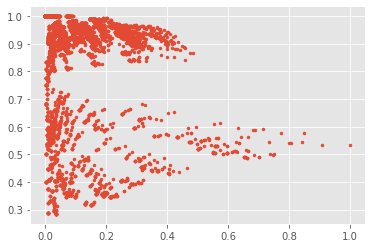

In [164]:
plt.scatter(table.n_gems_relative, table.concordance, marker='.')
plt.show()

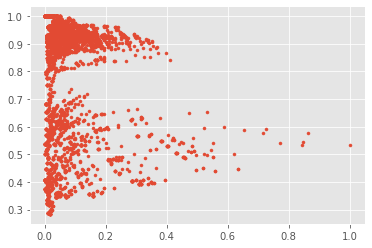

In [168]:
plt.scatter(table.n_tcrs_relative, table.concordance, marker='.')
plt.show()

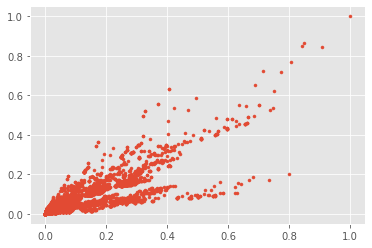

In [169]:
plt.scatter(table.n_gems_relative, table.n_tcrs_relative, marker='.')
plt.show()

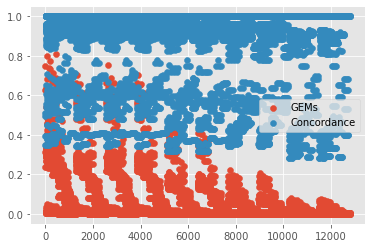

In [167]:
plt.scatter(table.index, table.n_gems_relative, label='GEMs')
plt.scatter(table.index, table.concordance, label='Concordance')
plt.legend()
plt.show()

In [15]:
table.describe()

,umi_count_TRA,delta_umi_TRA,umi_count_TRB,delta_umi_TRB,umi_count_mhc,delta_umi_mhc,concordance,n_gems,n_tcrs
count,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000
mean,4.000000,2.500000,8.000000,2.500000,7.500000,4.500000,0.756176,149.127578,14.968359
std,2.828538,2.500098,5.657075,2.500098,5.590388,3.354233,0.356684,245.754955,25.301365
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000,0.000000,3.750000,2.250000,0.586967,4.000000,1.000000
50%,4.000000,2.500000,8.000000,2.500000,7.500000,4.500000,0.941249,34.000000,5.000000
75%,6.000000,5.000000,12.000000,5.000000,11.250000,6.750000,1.000000,182.000000,19.000000
max,8.000000,5.000000,16.000000,5.000000,15.000000,9.000000,1.000000,2432.000000,388.000000


In [16]:
table.dtypes

umi_count_TRA                    int64
delta_umi_TRA                    int64
umi_count_TRB                    int64
delta_umi_TRB                    int64
tcr_category                    object
umi_count_mhc                    int64
delta_umi_mhc                    int64
single_barcode_mhc              object
exclude_specificity_singlet       bool
concordance                    float64
n_gems                           int64
n_tcrs                           int64
dtype: object

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


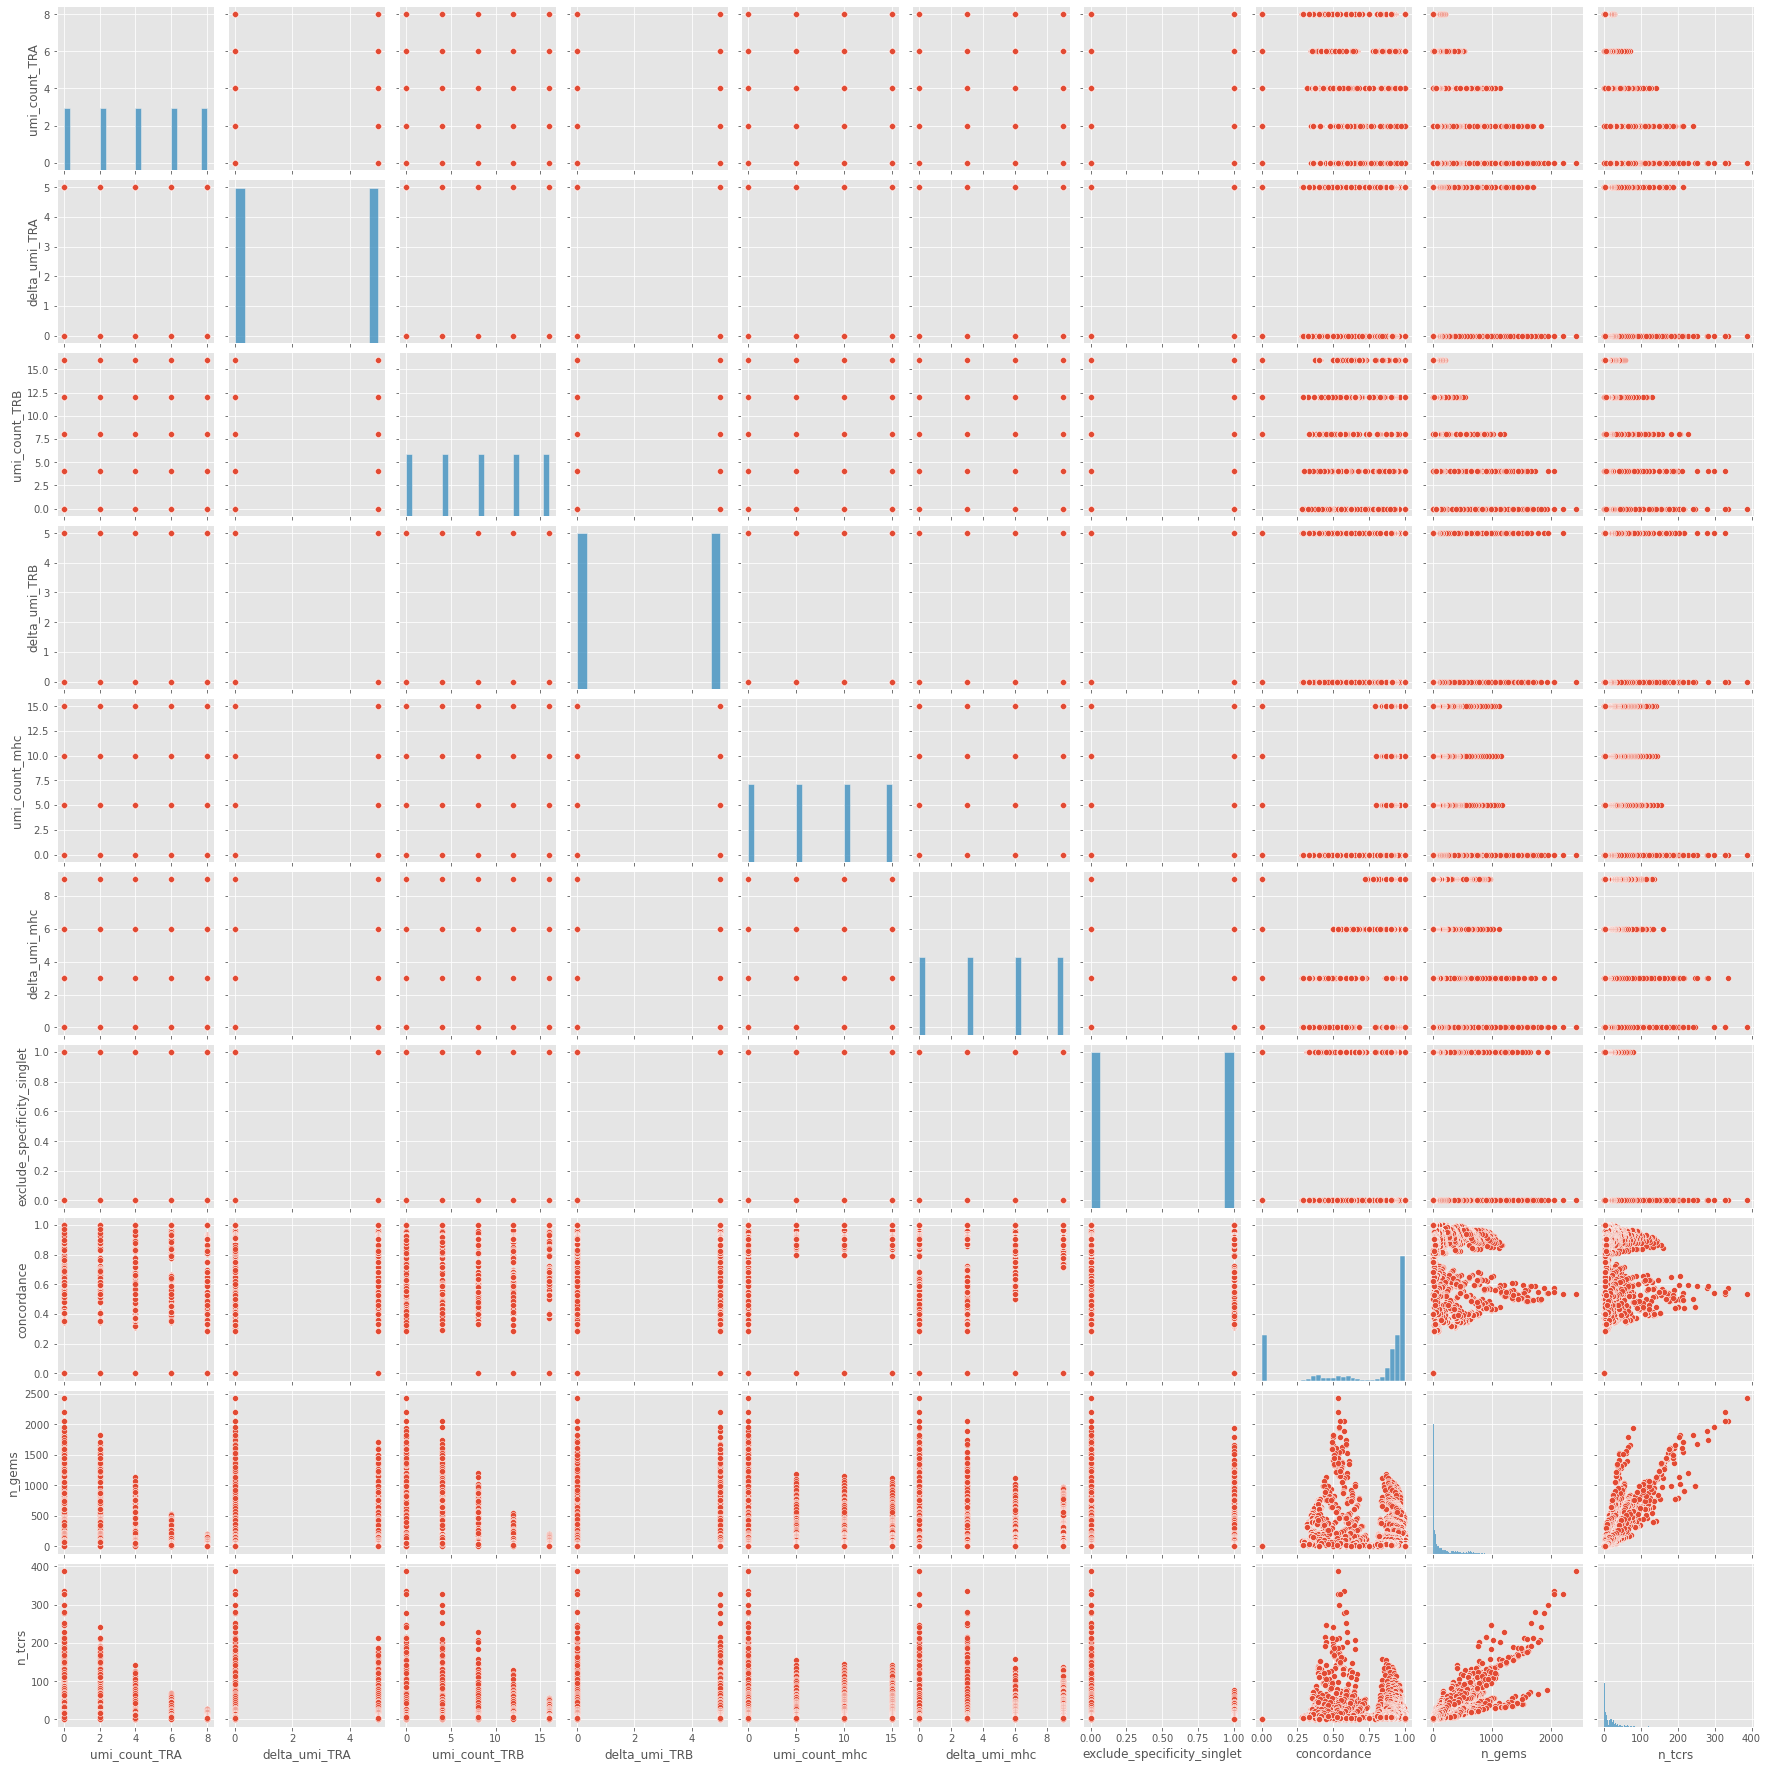

In [17]:
import seaborn as sns
sns.pairplot(table)

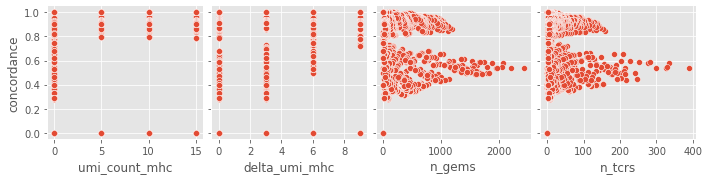

In [18]:
sns.pairplot(table,x_vars=['umi_count_mhc','delta_umi_mhc','n_gems','n_tcrs'],y_vars=['concordance'])

In [19]:
table.corr()

,umi_count_TRA,delta_umi_TRA,umi_count_TRB,delta_umi_TRB,umi_count_mhc,delta_umi_mhc,exclude_specificity_singlet,concordance,n_gems,n_tcrs
umi_count_TRA,1.000000e+00,-1.658763e-15,-2.001559e-15,-6.837360e-16,-5.090533e-16,1.803925e-15,2.610426e-15,-0.106569,-0.387575,-0.348797
delta_umi_TRA,-1.658763e-15,1.000000e+00,-7.413388e-16,-3.678724e-16,-1.458340e-16,-3.362675e-16,7.109174e-16,-0.006809,-0.029399,-0.057055
umi_count_TRB,-2.001559e-15,-7.413388e-16,1.000000e+00,-1.883130e-16,-6.486265e-17,-1.401408e-17,2.940734e-16,-0.376615,-0.356346,-0.255429
delta_umi_TRB,-6.837360e-16,-3.678724e-16,-1.883130e-16,1.000000e+00,-1.453772e-17,-2.648036e-19,5.465073e-17,0.001503,-0.007879,-0.026868
umi_count_mhc,-5.090533e-16,-1.458340e-16,-6.486265e-17,-1.453772e-17,1.000000e+00,6.720550e-18,1.370359e-17,0.153863,-0.158161,-0.173891
delta_umi_mhc,1.803925e-15,-3.362675e-16,-1.401408e-17,-2.648036e-19,6.720550e-18,1.000000e+00,5.420200e-18,0.116074,-0.128708,-0.118785
exclude_specificity_singlet,2.610426e-15,7.109174e-16,2.940734e-16,5.465073e-17,1.370359e-17,5.420200e-18,1.000000e+00,-0.097233,-0.045748,-0.315630
concordance,-1.065686e-01,-6.809084e-03,-3.766151e-01,1.503323e-03,1.538633e-01,1.160739e-01,-9.723338e-02,1.000000,0.090324,0.078800
n_gems,-3.875754e-01,-2.939876e-02,-3.563462e-01,-7.878773e-03,-1.581606e-01,-1.287078e-01,-4.574826e-02,0.090324,1.000000,0.827573
n_tcrs,-3.487969e-01,-5.705510e-02,-2.554293e-01,-2.686781e-02,-1.738906e-01,-1.187852e-01,-3.156296e-01,0.078800,0.827573,1.000000


<AxesSubplot:>

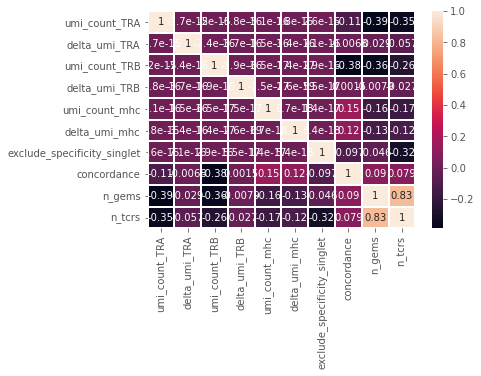

In [20]:
sns.heatmap(table.corr(),annot=True,lw=1)

In [ ]:
# https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c

In [21]:
table.columns

Index(['umi_count_TRA', 'delta_umi_TRA', 'umi_count_TRB', 'delta_umi_TRB',
       'tcr_category', 'umi_count_mhc', 'delta_umi_mhc', 'single_barcode_mhc',
       'exclude_specificity_singlet', 'concordance', 'n_gems', 'n_tcrs'],
      dtype='object')

In [22]:
table['s_tcr_category'] = table.tcr_category.astype(str)
table['s_single_barcode_mhc'] = table.single_barcode_mhc.astype(str)
table['s_exclude_specificity_singlet'] = table.exclude_specificity_singlet.astype(str)

SyntaxError: invalid character in identifier (<ipython-input-22-912da77996d3>, line 1)

In [198]:
X = table[['umi_count_TRA', 'delta_umi_TRA', 'umi_count_TRB', 'delta_umi_TRB',
       's_tcr_category', 'umi_count_mhc', 'delta_umi_mhc', 's_single_barcode_mhc',
       's_exclude_specificity_singlet']]

In [101]:
filter_bool = (((df.umi_count_TRA >= 6) | (df.umi_count_TRB >= 6)) & (df.umi_count_mhc >= 5))
flt = df[filter_bool].copy()
flt = calc_binding_concordance(flt, 'ct').sort_values(by=['ct','binding_concordance'])

In [136]:
flt.loc[flt.ct == 10, ['ct','cdr3_lst_TRA','umi_count_lst_TRA','cdr3_lst_TRB','umi_count_lst_TRB','peptide_HLA_lst','umi_count_lst_mhc','delta_umi_mhc','binding_concordance','peptide_HLA']].head(60)

,ct,cdr3_lst_TRA,umi_count_lst_TRA,cdr3_lst_TRB,umi_count_lst_TRB,peptide_HLA_lst,umi_count_lst_mhc,delta_umi_mhc,binding_concordance,peptide_HLA
746,10.0,[CALWEYGNKLVF],[4],[CASRVQFGVNTGELFF],[11],"[NLVPMVATV A0201, RAKFKQLL B0801, RQAYLTNQY A0...","[1, 1, 1, 1, 1, 1, 1, 3, 22, 29, 41]",1.401709,0.017544,ILKEPVHGV A0201
1152,10.0,[CALWEYGNKLVF],[4],[CASRVQFGVNTGELFF],[7],"[ICSSVDIHF A0101, TNQYMQRMASV A2401, TADVDAGSL...","[1, 1, 3, 3, 3, 15, 23, 24, 31]",1.278351,0.017544,CSSVDIHF A0101
2027,10.0,[CALWEYGNKLVF],[5],[CASRVQFGVNTGELFF],[7],"[ALPGVPPVPA A0201, ATTADVDAGSL A0101, ILKEPVHG...","[1, 1, 2, 16, 29, 30]",1.025641,0.017544,EERQAYLTNQY A0101
20,10.0,[CALWEYGNKLVF],[2],[CASRVQFGVNTGELFF],[16],"[QAYLTNQY A0101, FSAGAFILYN A0101, FSAGAFILYK ...","[1, 1, 1, 2, 2, 12, 66]",5.387755,0.947368,VTEHDTLLY A0101
43,10.0,[CALWEYGNKLVF],[1],[CASRVQFGVNTGELFF],[9],"[ATTADVDAGSL A0101, VTEHDTLLY A0101]","[1, 14]",11.200000,0.947368,VTEHDTLLY A0101
63,10.0,[CALWEYGNKLVF],[4],[CASRVQFGVNTGELFF],[6],"[SVDIHFDPG A0101, FLDTNQVV A0201, ATTADVDAGSL ...","[1, 1, 2, 2, 74]",32.888889,0.947368,VTEHDTLLY A0101
92,10.0,[CALWEYGNKLVF],[3],[CASRVQFGVNTGELFF],[10],"[ILKEPVHGV A0201, GPFPGNLV B0702, ATTADVDAGSL ...","[1, 1, 1, 1, 9, 33]",3.567568,0.947368,VTEHDTLLY A0101
116,10.0,[CALWEYGNKLVF],[4],[CASRVQFGVNTGELFF],[9],"[TPRVTGGGAM B0702, ATTADVDAGSL A0101, SVDIHFDP...","[1, 1, 1, 2, 5, 5, 30]",5.714286,0.947368,VTEHDTLLY A0101
159,10.0,[CALWEYGNKLVF],[7],[CASRVQFGVNTGELFF],[10],"[TNQYMQRMASV A2401, RQAYLTNQY A0101, FSAGAFILY...","[1, 1, 1, 1, 1, 1, 2, 2, 49, 74]",1.502538,0.947368,VTEHDTLLY A0101
206,10.0,[CALWEYGNKLVF],[2],[CASRVQFGVNTGELFF],[7],"[TNQYMQRMASV A2401, TPRVTGGGAM B0702, SVDIHFDP...","[1, 1, 1, 1, 1, 1, 3, 8, 23, 204]",8.774194,0.947368,VTEHDTLLY A0101


In [137]:
filter_bool = (((df.umi_count_TRA >= 5) | (df.umi_count_TRB >= 5)) &
               (df.umi_count_mhc >= 5) & (df.no_filtration) & (df.delta_umi_mhc >= 0))
df[filter_bool]

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr3_TRA,...,likely_HLA_mhc,peptide,peptide_lst,peptide_HLA,peptide_HLA_lst,epitope,epitope_lst,gems_per_specificity,gems_per_clonotype,binding_concordance
0,AAACCTGAGAGGTAGA-1,clonotype2,2.0,2.0,TRAV16;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC'],['TRBV7-3;;TRBJ2-1;TRBC2'],509.0,CALRDMEYGNKLVF,...,0.0,RAKFKQLL,['ALPGVPPV' 'RQAYLTNQY' 'VTEHDTLLY' 'EERQAYLTN...,RAKFKQLL B0801,"[ALPGVPPV A0201, RQAYLTNQY A0101, VTEHDTLLY A0...",V17_B8 EBV BZLF1 (C9),['06_1_1' '45_1_49' 'V15_A1 CMV pp50 VTE' '...,390.0,575.0,0.678261
6,AAACCTGTCGAATCCA-1,clonotype2,2.0,2.0,TRAV16;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC'],['TRBV7-3;;TRBJ2-1;TRBC2'],551.0,CALRDMEYGNKLVF,...,0.0,RAKFKQLL,['TPRVTGGGAM' 'LLFERPHTM' 'HTGEKHYAC' 'FSAGAFI...,RAKFKQLL B0801,"[TPRVTGGGAM B0702, LLFERPHTM B0801, HTGEKHYAC ...",V17_B8 EBV BZLF1 (C9),['V14_B7 CMV pp65 TPR' '47_1_32' '47_1_82' ...,390.0,575.0,0.678261
7,AAACGGGAGGACATTA-1,0,0.0,39.0,TRAV3;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC' 'TRAV3;TRAJ47;TRAC'],['TRBV27;;TRBJ2-7;TRBC2' 'TRBV7-3;;TRBJ2-1;TRB...,609.0,CAVNYGNKLVF,...,0.0,RAKFKQLL,['TPRVTGGGAM' 'IRHKRQSWV' 'EERQAYLTNQY' 'MDMFS...,RAKFKQLL B0801,"[TPRVTGGGAM B0702, IRHKRQSWV B0801, EERQAYLTNQ...",V17_B8 EBV BZLF1 (C9),['V14_B7 CMV pp65 TPR' '47_1_94' '45_1_3' '...,0.0,0.0,0.000000
11,AAACGGGGTTAGGGTG-1,clonotype2,2.0,2.0,TRAV16;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC'],['TRBV7-3;;TRBJ2-1;TRBC2'],557.0,CALRDMEYGNKLVF,...,0.0,RAKFKQLL,['VIRHKRQSW' 'SQKVLRHM' 'VTEHDTLLY' 'AMLIRDRL'...,RAKFKQLL B0801,"[VIRHKRQSW B0801, SQKVLRHM B0801, VTEHDTLLY A0...",V17_B8 EBV BZLF1 (C9),['47_1_69' '47_1_90' 'V15_A1 CMV pp50 VTE' ...,390.0,575.0,0.678261
14,AAAGCAAAGCTCTCGG-1,clonotype7,7.0,13.0,TRAV29/DV5;TRAJ54;TRAC,TRBV7-9;;TRBJ2-7;TRBC2,['TRAV29/DV5;TRAJ54;TRAC'],['TRBV7-9;;TRBJ2-7;TRBC2'],508.0,CAARPGAQKLVF,...,0.0,VTEHDTLLY,['ATTADVDAGSL' 'RAKFKQLL' 'VTEHDTLLY'],VTEHDTLLY A0101,"[ATTADVDAGSL A0101, RAKFKQLL B0801, VTEHDTLLY ...",V15_A1 CMV pp50 VTE,['45_1_1' 'V17_B8 EBV BZLF1 (C9)' 'V15_A1 CMV...,30.0,34.0,0.882353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,TGGTTAGTCGTAGGTT-1,clonotype2,2.0,4.0,0,TRBV7-3;;TRBJ2-1;TRBC2,0,['TRBV7-3;;TRBJ2-1;TRBC2'],0.0,0,...,0.0,RAKFKQLL,['AALPGVPPV' 'NLVPMVATV' 'VTEHDTLLY' 'RAKFKQLL'],RAKFKQLL B0801,"[AALPGVPPV A0201, NLVPMVATV A0201, VTEHDTLLY A...",V17_B8 EBV BZLF1 (C9),['06_1_30' 'V13_A2 CMV pp65 NLV' 'V15_A1 C...,390.0,575.0,0.678261
2411,TTCCCAGCATTGGCGC-1,clonotype4,4.0,7.0,0,TRBV4-2;;TRBJ2-7;TRBC2,0,['TRBV4-2;;TRBJ2-7;TRBC2'],0.0,0,...,0.0,VTEHDTLLY,['ATTADVDAGSL' 'SVDIHFDPG' 'TNQYMQRMASV' 'NLVP...,VTEHDTLLY A0101,"[ATTADVDAGSL A0101, SVDIHFDPG A0101, TNQYMQRMA...",V15_A1 CMV pp50 VTE,['45_1_1' '45_1_13' '45_1_61' 'V13_A2 CMV pp...,151.0,177.0,0.853107
2421,TTGCCGTTCCCATTAT-1,clonotype6,6.0,32.0,0,TRBV19;;TRBJ2-2;TRBC2,0,['TRBV19;;TRBJ2-2;TRBC2'],0.0,0,...,0.0,VTEHDTLLY,['FSAGAFILYN' 'ATTADVDAGSL' 'VTEHDTLLY'],VTEHDTLLY A0101,"[FSAGAFILYN A0101, ATTADVDAGSL A0101, VTEHDTLL...",V15_A1 CMV pp50 VTE,['45_1_5' '45_1_1' 'V15_A1 CMV pp50 VTE'],71.0,74.0,0.959459
2425,TTGCGTCTCTTATCTG-1,clonotype11,11.0,30.0,0,TRBV9;;TRBJ2-7;TRBC2,0,['TRBV9;;TRBJ2-7;TRBC2'],0.0,0,...,0.0,VTEHDTLLY,['ATTADVDAGSL' 'VTEHDTLLY'],VTEHDTLLY A0101,"[ATTADVDAGSL A0101, VTEHDTLLY A0101]",V15_A1 CMV pp50 VTE,['45_1_1' 'V15_A1 CMV pp50 VTE'],21.0,24.0,0.875000


In [121]:
GEM_LIST = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9_CAT_IONTORRENT_KMA_AKB/specificity_matrix/peptide_per_clonotype_by_gem_size/ct/umi_delta0/no_filtration/unique_gems/b5.t5.ecs_False.ess_False.lst'

In [123]:
gem_lst = np.loadtxt(GEM_LIST, dtype='U20')

In [138]:
df.loc[filter_bool & ~df.gem.isin(gem_lst), ['ct','cdr3_lst_TRA','umi_count_lst_TRA','umi_count_TRA','cdr3_lst_TRB','umi_count_lst_TRB','umi_count_TRB','peptide_HLA_lst','umi_count_lst_mhc','delta_umi_mhc','binding_concordance','peptide_HLA']]

,ct,cdr3_lst_TRA,umi_count_lst_TRA,umi_count_TRA,cdr3_lst_TRB,umi_count_lst_TRB,umi_count_TRB,peptide_HLA_lst,umi_count_lst_mhc,delta_umi_mhc,binding_concordance,peptide_HLA
153,2.0,[CALRDMEYGNKLVF],[6],6.0,[CASSLIVSGGANEQFF],[18],18.0,"[TNQYMQRMASV A2401, RAKFKQLL B0801, ATTADVDAGS...","[1, 1, 1, 1, 11, 18]",1.600000,0.196522,VTEHDTLLY A0101
169,2.0,[CALRDMEYGNKLVF],[2],2.0,[CASSLIVSGGANEQFF],[13],13.0,"[QAYLTNQY A0101, ALPGVPPV A0201, VTEHDTLLY A01...","[1, 1, 1, 4, 16]",3.764706,0.001739,AMLIRDRL B0801
535,2.0,[CALRDMEYGNKLVF],[5],5.0,[CASSLIVSGGANEQFF],[8],8.0,"[SAGAFILYK A0101, MDMFSDEQLKV A2401, RRKVPAQRL...","[1, 1, 2, 2, 3, 18, 26, 33, 40]",1.203008,0.196522,VTEHDTLLY A0101
721,2.0,[CALRDMEYGNKLVF],[1],1.0,[CASSLIVSGGANEQFF],[13],13.0,"[FSAGAFILYK A0101, LFSAGAFIL A0101, RQAYLTNQY ...","[1, 1, 1, 3, 3, 30, 63]",2.082645,0.196522,VTEHDTLLY A0101
